In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def generate_dataset(X,Y,
        x0,y0,R,
        error=0.3,drop_rate=0.1
        ):
    df=pd.DataFrame({'x':X,'y':Y})
    df_in_circle=df[(df['x']-x0)**2+(df['y']-y0)**2<R**2]
    df_in_circle.loc[:, 'x'] += np.random.uniform(-error, error, len(df_in_circle))
    df_in_circle.loc[:, 'y'] += np.random.uniform(-error, error, len(df_in_circle))
    df_in_circle=df_in_circle.sample(frac=1-drop_rate)
    return df_in_circle

def transform_dataset(x0,y0,theta,df_in_circle):
    # 平移df_in_circle到原点
    df_in_circle.loc[:, 'x'] -= x0
    df_in_circle.loc[:, 'y'] -= y0
    # 绕圆心旋转df_in_circle中的点theta角
    x_new=df_in_circle['x']*np.cos(theta)-df_in_circle['y']*np.sin(theta)
    y_new=df_in_circle['x']*np.sin(theta)+df_in_circle['y']*np.cos(theta)
    df_in_circle['x']=x_new
    df_in_circle['y']=y_new
    return df_in_circle


In [23]:
filename='axicon_pattern_crossflower.csv'
df = pd.read_csv(filename)
X=df['x']
Y=df['y']

x0,y0=np.random.uniform(-20,20,2)
measure_diameter=17
theta=np.random.uniform(0,2*np.pi)
theta=0

df_in_circle=generate_dataset(X,Y,x0,y0,measure_diameter/2,error=0.1)
df_in_circle=transform_dataset(x0,y0,theta,df_in_circle)
df_in_circle.to_csv('axicon_pattern_crossflower_measure.csv',index=False)

data_measured=df_in_circle
data_original=df

In [24]:
def ransac_translation_focused_sampling(data, model, n_iter, threshold, radius):
    best_translation = None
    max_inliers = 0

    # Coordinates
    data_coords = data[['x', 'y']].values
    model_coords = model[['x', 'y']].values

    for _ in range(n_iter):
        # Randomly select a central point from the model
        center_idx = np.random.choice(len(model_coords))
        center_point = model_coords[center_idx]

        # Find points within a certain radius from the center point
        distances = np.linalg.norm(model_coords - center_point, axis=1)
        close_points_idx = np.where(distances < radius)[0]
        
        selected_model_points = model_coords[close_points_idx]

        # Find nearest neighbors in the data for these model points
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(data_coords)
        distances, indices = nbrs.kneighbors(selected_model_points)

        # Calculate the translation using the mean of the selected points differences
        model_matched = selected_model_points
        data_matched = data_coords[indices.flatten()]
        translation = np.mean(data_matched - model_matched, axis=0)

        # Apply translation
        translated_model = model_coords + translation

        # Count inliers
        nbrs.fit(translated_model)
        distances, _ = nbrs.kneighbors(data_coords)
        inliers = np.sum(distances < threshold)

        # Update the best translation if the current one has more inliers
        if inliers > max_inliers:
            max_inliers = inliers
            best_translation = translation

    return best_translation

# Updated RANSAC parameters for focused sampling
radius_sampling = 10  # Define an appropriate radius based on the dataset characteristics
n_iter_translation=10000
threshold_translation=0.001
# Run RANSAC with focused sampling
best_translation_focused = ransac_translation_focused_sampling(
    data_measured, data_original, n_iter_translation, threshold_translation, radius_sampling)
best_translation_focused


In [ ]:
def ransac_translation_focused_sampling(data, model, n_iter, threshold, radius):
    best_translation = None
    max_inliers = 0

    # Coordinates
    data_coords = data[['x', 'y']].values
    model_coords = model[['x', 'y']].values

    for _ in range(n_iter):
        # Randomly select a central point from the model
        center_idx = np.random.choice(len(model_coords))
        center_point = model_coords[center_idx]

        # Find points within a certain radius from the center point
        distances = np.linalg.norm(model_coords - center_point, axis=1)
        close_points_idx = np.where(distances < radius)[0]
        
        selected_model_points = model_coords[close_points_idx]

        # Find nearest neighbors in the data for these model points
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(data_coords)
        distances, indices = nbrs.kneighbors(selected_model_points)

        # Calculate the translation using the mean of the selected points differences
        model_matched = selected_model_points
        data_matched = data_coords[indices.flatten()]
        translation = np.mean(data_matched - model_matched, axis=0)

        # Apply translation
        translated_model = model_coords + translation

        # Count inliers
        nbrs.fit(translated_model)
        distances, _ = nbrs.kneighbors(data_coords)
        inliers = np.sum(distances < threshold)

        # Update the best translation if the current one has more inliers
        if inliers > max_inliers:
            max_inliers = inliers
            best_translation = translation

    return best_translation

# Updated RANSAC parameters for focused sampling
radius_sampling = 10  # Define an appropriate radius based on the dataset characteristics
n_iter_translation=10000
threshold_translation=0.001
# Run RANSAC with focused sampling
best_translation_focused = ransac_translation_focused_sampling(
    data_measured, data_original, n_iter_translation, threshold_translation, radius_sampling)
best_translation_focused


In [25]:
print(x0,y0)
print(best_translation_focused)


6.978970159835601 11.807039054450446
None


In [26]:

# Apply the estimated transformation to the measured data
transformed_data_measured = data_measured[['x', 'y']].values - best_translation_focused

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

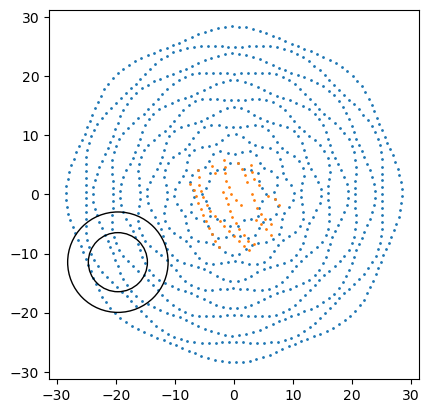

In [ ]:
# 画出df中的所有点
# 画出圆
# 画出圆内的点
fig,ax=plt.subplots()
ax.scatter(df['x'],df['y'],s=1)
circle_ori=plt.Circle((x0,y0),measure_diameter/2,fill=False)
ax.add_artist(circle_ori)
circle_test=plt.Circle((x0,y0),5,fill=False)
ax.add_artist(circle_test)

ax.scatter(transformed_data_measured[:,0],transformed_data_measured[:,1],s=1)
ax.set_aspect('equal')
plt.show()